# 🚀 Detect AI vs. Human-Generated Images  

### 📌 **Competition Overview**  
[🔗 **Kaggle Competition Link**](https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images/overview)  

This challenge focuses on distinguishing **AI-generated images** from **human-created** ones—a critical task in today’s digital landscape where deepfakes and synthetic media are rapidly evolving. Participants will develop ML models to classify images accurately while ensuring fairness and robustness.  

### 🎯 **Key Objectives**  
✔ **Detect AI-generated vs. human-created images** using a balanced dataset.  
✔ **Promote fairness & inclusivity** in AI by encouraging diverse participation.  
✔ **Enhance deepfake detection** to combat misinformation and uphold media authenticity.  
✔ **Foster innovation** through hands-on experience with real-world datasets.  


### 💡 **Why Join?**  
The reason why I'm tackling this project is to further my understanding of image classfication and to gain practical ML experience with industry-grade data. This will also help me to build a portfolio of projects that I can showcase to potential employers.



In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import timm

In [2]:

# Device-agnostic setup.
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)


Using device: mps


In [3]:
# Define the base directory and CSV path.
base_dir = "data/detect-ai-vs-human-generated-images"
csv_path = os.path.join(base_dir, "train.csv")

In [4]:
# Define training and validation transforms.
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [5]:
# Import our custom dataset.
from going_modular.custom_dataset import CustomImageDataset

# Create the full dataset using training transform.
full_dataset = CustomImageDataset(csv_file=csv_path, 
                                  base_dir=base_dir, 
                                  transform=train_transform)

# Split the dataset into train and validation subsets.
train_indices, val_indices = train_test_split(range(len(full_dataset)), 
                                              test_size=0.05, 
                                              random_state=42, 
                                              stratify=pd.read_csv(csv_path)['label'])
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)


In [ ]:
# Create DataLoaders.
batch_size = 64    # 128 will require about 27GB of VRAM.
num_workers = 4
train_loader = DataLoader(train_subset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers, 
                          pin_memory=True)

val_loader = DataLoader(val_subset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers, 
                        pin_memory=True)


## Model Selection

From this section, only run one cell that corresponds to the model you want to use.

In [9]:
import timm
import torch
import torch.nn as nn

def get_model_resnet50(num_classes=2, num_freeze_layers=1):
    """
    Creates a ResNet50 model (a standard CNN) with pretrained weights.
    
    The model is modified to output `num_classes` classes.
    The variable `num_freeze_layers` controls how many of the initial
    blocks are frozen. In ResNet50, we assume that by default we want
    only the last block (layer4) and the fully connected (fc) head trainable.
    
    Parameters:
      - num_classes (int): number of output classes.
      - num_freeze_layers (int): number of blocks (starting from the first) 
                                 whose parameters will be frozen. 
                                 Default is 1 (freeze all except 'layer4' and 'fc').
    
    Returns:
      - model (nn.Module): The modified ResNet50 model.
    """
    model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
    
    # For ResNet50 the children are typically: conv1, bn1, layer1, layer2, layer3, layer4, fc.
    # Here we freeze all blocks except the last "layer4" and the classifier "fc".
    if num_freeze_layers >= 1:
        for name, module in model.named_children():
            if name not in ['layer4', 'fc']:
                for param in module.parameters():
                    param.requires_grad = False
    return model
  
  
# Set the number of blocks to keep trainable.
num_freeze_layers = 1

# Initialize ResNet50 model.
resnet_model = get_model_resnet50(num_classes=2, num_freeze_layers=num_freeze_layers)

# Example: Print out which parameters are trainable.
print("ResNet50 trainable parameters:")
for name, param in resnet_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


ResNet50 trainable parameters:
conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.0.conv3.weight: requires_grad = False
layer1.0.bn3.weight: requires_grad = False
layer1.0.bn3.bias: requires_grad = False
layer1.0.downsample.0.weight: requires_grad = False
layer1.0.downsample.1.weight: requires_grad = False
layer1.0.downsample.1.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer1.1.conv3.weight: requires_grad = False
layer1.1.bn3.weight: re

In [10]:

def get_model_efficientnet(num_classes=2, num_freeze_layers=1):
    """
    Creates an EfficientNet-B3 model with pretrained weights.
    
    EfficientNet models in timm have a `blocks` attribute.
    This function freezes the early blocks and leaves the last `num_freeze_layers`
    unfrozen. For example, using num_freeze_layers=1 means only the very last block
    (plus the classifier head) will be trainable.
    
    Parameters:
      - num_classes (int): number of output classes.
      - num_freeze_layers (int): number of blocks to leave trainable starting from the end.
    
    Returns:
      - model (nn.Module): The modified EfficientNet-B3 model.
    """
    model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
    
    if hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        # Freeze blocks from 0 to total_blocks - num_freeze_layers.
        for i in range(total_blocks - num_freeze_layers):
            for param in model.blocks[i].parameters():
                param.requires_grad = False
    return model

# Set the number of blocks to keep trainable.
num_freeze_layers = 1

# Initialize EfficientNet-B3 model.
efficientnet_model = get_model_efficientnet(num_classes=2, num_freeze_layers=num_freeze_layers)

# Example: Print out which parameters are trainable.
print("EfficientNet-B3 trainable parameters:")
for name, param in efficientnet_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

EfficientNet-B3 trainable parameters:
conv_stem.weight: requires_grad = True
bn1.weight: requires_grad = True
bn1.bias: requires_grad = True
blocks.0.0.conv_dw.weight: requires_grad = False
blocks.0.0.bn1.weight: requires_grad = False
blocks.0.0.bn1.bias: requires_grad = False
blocks.0.0.se.conv_reduce.weight: requires_grad = False
blocks.0.0.se.conv_reduce.bias: requires_grad = False
blocks.0.0.se.conv_expand.weight: requires_grad = False
blocks.0.0.se.conv_expand.bias: requires_grad = False
blocks.0.0.conv_pw.weight: requires_grad = False
blocks.0.0.bn2.weight: requires_grad = False
blocks.0.0.bn2.bias: requires_grad = False
blocks.0.1.conv_dw.weight: requires_grad = False
blocks.0.1.bn1.weight: requires_grad = False
blocks.0.1.bn1.bias: requires_grad = False
blocks.0.1.se.conv_reduce.weight: requires_grad = False
blocks.0.1.se.conv_reduce.bias: requires_grad = False
blocks.0.1.se.conv_expand.weight: requires_grad = False
blocks.0.1.se.conv_expand.bias: requires_grad = False
blocks.0

In [8]:

def get_model_vit(num_classes=2, num_freeze_layers=1):
    """
    Creates a Vision Transformer (ViT) model with pretrained weights.
    
    This function freezes the first transformer blocks (and, if desired, the patch embedding)
    so that only the last `num_freeze_layers` blocks (plus the classification head) remain trainable.
    
    Parameters:
      - num_classes (int): number of output classes.
      - num_freeze_layers (int): number of transformer blocks (starting from the end)
                                 to keep trainable.
    
    Returns:
      - model (nn.Module): The modified ViT model.
    """
    model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    
    if hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        # Freeze transformer blocks from 0 to (total_blocks - num_freeze_layers)
        for i in range(total_blocks - num_freeze_layers):
            for param in model.blocks[i].parameters():
                param.requires_grad = False
        
        # Optionally, freeze the initial patch embedding if desired.
        if hasattr(model, 'patch_embed'):
            for param in model.patch_embed.parameters():
                param.requires_grad = False
                
    return model

# Set the number of transformer blocks to keep trainable.
num_freeze_layers = 1

# Initialize ViT model.
vit_model = get_model_vit(num_classes=2, num_freeze_layers=num_freeze_layers)

# Example: Print out which parameters are trainable.
print("ViT trainable parameters:")
for name, param in vit_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

ViT trainable parameters:
cls_token: requires_grad = True
pos_embed: requires_grad = True
patch_embed.proj.weight: requires_grad = False
patch_embed.proj.bias: requires_grad = False
blocks.0.norm1.weight: requires_grad = False
blocks.0.norm1.bias: requires_grad = False
blocks.0.attn.qkv.weight: requires_grad = False
blocks.0.attn.qkv.bias: requires_grad = False
blocks.0.attn.proj.weight: requires_grad = False
blocks.0.attn.proj.bias: requires_grad = False
blocks.0.norm2.weight: requires_grad = False
blocks.0.norm2.bias: requires_grad = False
blocks.0.mlp.fc1.weight: requires_grad = False
blocks.0.mlp.fc1.bias: requires_grad = False
blocks.0.mlp.fc2.weight: requires_grad = False
blocks.0.mlp.fc2.bias: requires_grad = False
blocks.1.norm1.weight: requires_grad = False
blocks.1.norm1.bias: requires_grad = False
blocks.1.attn.qkv.weight: requires_grad = False
blocks.1.attn.qkv.bias: requires_grad = False
blocks.1.attn.proj.weight: requires_grad = False
blocks.1.attn.proj.bias: requires_gra

In [12]:

def get_model_convnext(num_classes=2, num_freeze_layers=1):
    """
    Creates a ConvNeXt Base model with pretrained weights.
    
    ConvNeXt models have a list of blocks in the `blocks` attribute.
    The function freezes all blocks except the last `num_freeze_layers` blocks, so you can
    experiment with how many blocks you want unfrozen.
    
    Parameters:
      - num_classes (int): number of output classes.
      - num_freeze_layers (int): number of blocks (from the end) to keep trainable.
    
    Returns:
      - model (nn.Module): The modified ConvNeXt model.
    """
    model = timm.create_model('convnext_base', pretrained=True, num_classes=num_classes)
    
    if hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        for i in range(total_blocks - num_freeze_layers):
            for param in model.blocks[i].parameters():
                param.requires_grad = False
    return model
  
# Set the number of blocks to keep trainable.
num_freeze_layers = 1

# Initialize ConvNeXt model.
convnext_model = get_model_convnext(num_classes=2, num_freeze_layers=num_freeze_layers)

# Example: Print out which parameters are trainable.
print("ConvNeXt trainable parameters:")
for name, param in convnext_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


model.safetensors:  15%|#4        | 52.4M/354M [00:00<?, ?B/s]

KeyboardInterrupt: 

## Training and Validation

In [9]:
# Import the train_model function from our module.
from going_modular.train_model import train_model

# Import necessary libraries.
import torch
import torch.nn as nn
import torch.optim as optim

# Move model to the appropriate device.
vit_model = vit_model.to(device)

# Define the loss function.
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer. Only update parameters that require grad.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vit_model.parameters()), lr=1e-4)

# Define a learning rate scheduler (for example, a StepLR that reduces LR every 5 epochs by 50%).
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Now, call the train_model function to train the model.
history = train_model(model=vit_model,
                      train_loader=train_loader,
                      val_loader=val_loader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      epochs=3,
                      device=device,
                      base_lr=1e-4,
                      patience=3,
                      unfreeze_epoch=3,
                      unfreeze_option="last")

# Print the training history to summarize the results.
print("Training complete!")
print(history)

Epochs:   0%|          | Epoch 0/3

Training:   0%|          | 0/594 batches

Validation:   0%|          | 0/32 batches

Epoch 1: Train Loss: 0.1890, Train Acc: 0.9200, Val Loss: 0.1454, Val Acc: 0.9445


Training:   0%|          | 0/594 batches

Validation:   0%|          | 0/32 batches

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 2: Train Loss: 0.0907, Train Acc: 0.9645, Val Loss: 0.1033, Val Acc: 0.9590


Training:   0%|          | 0/594 batches

Validation:   0%|          | 0/32 batches

Epoch 3: Train Loss: 0.0566, Train Acc: 0.9778, Val Loss: 0.0966, Val Acc: 0.9645

Unfreezing the last block for fine-tuning...
Training complete!
{'train_loss': [0.18897588282811006, 0.09066420299443843, 0.05662003038786564], 'train_acc': [0.9200416052243522, 0.9644775647777544, 0.977814935748894], 'val_loss': [0.14542651694527026, 0.10333264374983436, 0.09664682483392814], 'val_acc': [0.9444722361180591, 0.9589794897448725, 0.9644822411205602]}


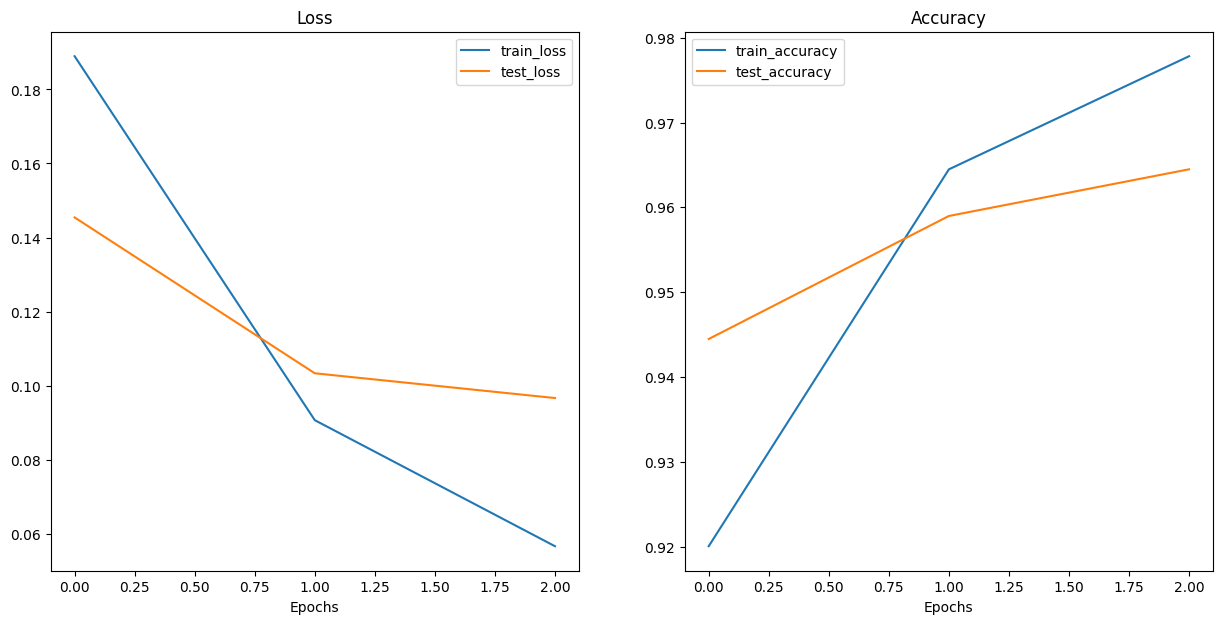

In [10]:
# Cell: Plot loss/accuracy curves and compute F1, precision, recall on validation set

# 1. Import what we need
from helper_functions import plot_loss_curves
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

# 2. Prepare the results dict for plotting (helper expects keys: train_loss, test_loss, train_acc, test_acc)
results = {
    "train_loss": history["train_loss"],
    "test_loss":  history["val_loss"],
    "train_acc":  history["train_acc"],
    "test_acc":   history["val_acc"]
}

# 3. Plot loss and accuracy curves
plot_loss_curves(results)


In [11]:

# 4. Compute predictions on the validation set
vit_model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in val_loader:
        X = X.to(device)
        logits = vit_model(X)
        # get probability for class “1” (AI-generated) via softmax
        probs = torch.softmax(logits, dim=1)[:, 1]
        # threshold at 0.5
        preds = (probs >= 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# 5. Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall:    {recall:.4f}")
print(f"Validation F1 Score:  {f1:.4f}")

Validation Precision: 0.9765
Validation Recall:    0.9575
Validation F1 Score:  0.9669


In [18]:
# Cell: Generate submission.csv using the 'id' column directly as the image path

import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Read test.csv
test_csv_path = os.path.join(base_dir, "test.csv")
df_test       = pd.read_csv(test_csv_path)  # expects an 'id' column
print("Test CSV sample:")
print(df_test.head())


Test CSV sample:
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [19]:

# 2. Dataset that treats each 'id' as the relative path from base_dir
class TestImageDataset(Dataset):
    def __init__(self, df, base_dir, transform=None):
        """
        df: DataFrame with an 'id' column whose entries are paths
            like 'test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg'
        base_dir: the root folder containing test_data_v2
        transform: validation transforms
        """
        self.df      = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        id_val = row["id"]
        img_path = os.path.join(self.base_dir, id_val)
        image    = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, id_val


In [20]:

# 3. Create DataLoader with num_workers=0
test_dataset = TestImageDataset(df_test, base_dir, transform=val_transform)
test_loader  = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,    # avoid pickling issues
    pin_memory=True
)


In [21]:

# 4. Run inference and collect ids & predictions
vit_model.eval()
ids_out, preds_out = [], []

with torch.inference_mode():
    for imgs, ids in test_loader:
        imgs   = imgs.to(device)
        logits = vit_model(imgs)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        preds  = (probs >= 0.5).long().cpu().numpy()
        ids_out.extend(ids)        # ids are strings like 'test_data_v2/xxx.jpg'
        preds_out.extend(preds)

# 5. Build submission DataFrame—strip any directory prefix if needed
#    Here we assume the competition expects exactly the same 'id' strings.
submission = pd.DataFrame({
    "id":    ids_out,
    "label": preds_out
})
submission.to_csv("submission.csv", index=False)
print("→ submission.csv saved (columns: id, label)")

→ submission.csv saved (columns: id, label)


In [23]:
# Cell: create the folder structure
import os

base = "demos/ai-vs-human-pictures"
os.makedirs(os.path.join(base, "models"),      exist_ok=True)
os.makedirs(os.path.join(base, "examples/ai"),     exist_ok=True)
os.makedirs(os.path.join(base, "examples/non-ai"), exist_ok=True)
# we'll put model.pth in demos/.../models/

In [24]:
# Cell: save your ViT weights
import torch

# move to CPU just in case
vit_model = vit_model.to("cpu")
torch.save(vit_model.state_dict(), "demos/ai-vs-human-pictures/models/model.pth")
print("Model saved to demos/ai-vs-human-pictures/models/model.pth")

Model saved to demos/ai-vs-human-pictures/models/model.pth


In [25]:
# Cell: copy 10 AI and 10 human images from your train split
import os, shutil, pandas as pd

df = pd.read_csv("data/detect-ai-vs-human-generated-images/train.csv")
base_dir = "data/detect-ai-vs-human-generated-images"

# pick the first 10 of each class
ai_imgs    = df[df.label == 1].head(10)["file_name"].tolist()
human_imgs = df[df.label == 0].head(10)["file_name"].tolist()

for fn in ai_imgs:
    src = os.path.join(base_dir, fn)
    dst = os.path.join("demos/ai-vs-human-pictures/examples/ai", os.path.basename(fn))
    shutil.copy(src, dst)

for fn in human_imgs:
    src = os.path.join(base_dir, fn)
    dst = os.path.join("demos/ai-vs-human-pictures/examples/non-ai", os.path.basename(fn))
    shutil.copy(src, dst)

print("Copied 10 AI images and 10 human images into demos/ai-vs-human-pictures/examples/")

Copied 10 AI images and 10 human images into demos/ai-vs-human-pictures/examples/


In [26]:
# Cell: list out the example filenames
import os

ai_folder    = "demos/ai-vs-human-pictures/examples/ai"
human_folder = "demos/ai-vs-human-pictures/examples/non-ai"

print("AI examples:")
print(os.listdir(ai_folder))
print("\nHuman examples:")
print(os.listdir(human_folder))

AI examples:
['a02c596a83164f82b794b1b67ff7bcec.jpg', 'fc9dbe25e2d54014a7fafd53198632f5.jpg', '774aeb00dbf44520bf3be78bb600bda9.jpg', 'a6dcb93f596a43249135678dfcfc17ea.jpg', '615df26ce9494e5db2f70e57ce7a3a4f.jpg', '5d81fa12bc3b4cea8c94a6700a477cf2.jpg', '340014208f2e46afb5fb1b0837bf52cf.jpg', 'dea116642f354126b79d048de24010e3.jpg', 'e67085fb6d814cbabe08f978c738f3f7.jpg', '4aea3b876247467c8d3713d4920148ab.jpg']

Human examples:
['91f5e18cdfde4d6b929561f4ec150bbf.jpg', '8542fe161d9147be8e835e50c0de39cd.jpg', '041be3153810433ab146bc97d5af505c.jpg', '33a6a93ef8074ef684291557a00a408b.jpg', '6b1b4ec385c346cdb4b5c6e74837df2b.jpg', '09708379751e44d0bc908d8652d0db3e.jpg', '25ea852f30594bc5915eb929682af429.jpg', '041c36d9269146cdb88e7526e3b91651.jpg', 'c098c9452c6748ca8d94134d898da05a.jpg', '2275dc00b50f4183812b5c3930365598.jpg']


In [27]:
%%writefile demos/ai-vs-human-pictures/requirements.txt
torch
torchvision
timm
gradio
Pillow

Writing demos/ai-vs-human-pictures/requirements.txt


In [37]:

from pathlib import Path
import torch
import timm
import gradio as gr
from PIL import Image
import torchvision.transforms as transforms

# — determine base directory —
try:
    BASE_DIR = Path(__file__).parent
except NameError:
    # when running in a notebook
    BASE_DIR = Path.cwd() / "demos" / "ai-vs-human-pictures"

MODEL_PATH    = BASE_DIR / "models" / "model.pth"
EXAMPLES_DIR  = BASE_DIR / "examples"
AI_DIR        = EXAMPLES_DIR / "ai"
HUMAN_DIR     = EXAMPLES_DIR / "non-ai"

# — load model —
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(checkpoint)
model.eval()

# — preprocessing (same as validation) —
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# — build example list: alternate AI / human —
ai_images    = sorted(AI_DIR.glob("*.*"))
human_images = sorted(HUMAN_DIR.glob("*.*"))
examples = []
for ai_img, human_img in zip(ai_images, human_images):
    examples.append([str(ai_img)])
    examples.append([str(human_img)])

# — inference function —
def classify(image):
    img    = image.convert("RGB")
    batch  = val_transform(img).unsqueeze(0)
    with torch.inference_mode():
        logits = model(batch)
        probs  = torch.softmax(logits, dim=1)[0].tolist()
    return {"Human": probs[0], "AI": probs[1]}

# — Gradio interface —
demo = gr.Interface(
    fn=classify,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    examples=examples,
    examples_per_page=20,
    title="AI vs Human Image Detector",
    description="Upload an image or click one of the 20 examples below to see P(Human) vs. P(AI)."
)

if __name__ == "__main__":
    demo.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [ ]:
%%writefile demos/ai-vs-human-pictures/app.py
from pathlib import Path
import torch
import timm
import gradio as gr
from PIL import Image
import torchvision.transforms as transforms

# — determine base directory —
try:
    BASE_DIR = Path(__file__).parent
except NameError:
    # when running in a notebook
    BASE_DIR = Path.cwd() / "demos" / "ai-vs-human-pictures"

MODEL_PATH    = BASE_DIR / "models" / "model.pth"
EXAMPLES_DIR  = BASE_DIR / "examples"
AI_DIR        = EXAMPLES_DIR / "ai"
HUMAN_DIR     = EXAMPLES_DIR / "non-ai"

# — load model —
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(checkpoint)
model.eval()

# — preprocessing (same as validation) —
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# — build example list: alternate AI / human —
ai_images    = sorted(AI_DIR.glob("*.*"))
human_images = sorted(HUMAN_DIR.glob("*.*"))
examples = []
for ai_img, human_img in zip(ai_images, human_images):
    examples.append([str(ai_img)])
    examples.append([str(human_img)])

# — inference function —
def classify(image):
    img    = image.convert("RGB")
    batch  = val_transform(img).unsqueeze(0)
    with torch.inference_mode():
        logits = model(batch)
        probs  = torch.softmax(logits, dim=1)[0].tolist()
    return {"Human": probs[0], "AI": probs[1]}

# — Gradio interface —
demo = gr.Interface(
    fn=classify,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    examples=examples,
    examples_per_page=20,
    title="AI vs Human Image Detector",
    description="Upload an image or click one of the 20 examples below to see whether it is an AI-generated image or a real image!"
)

if __name__ == "__main__":
    demo.launch()

Overwriting demos/ai-vs-human-pictures/app.py
